started


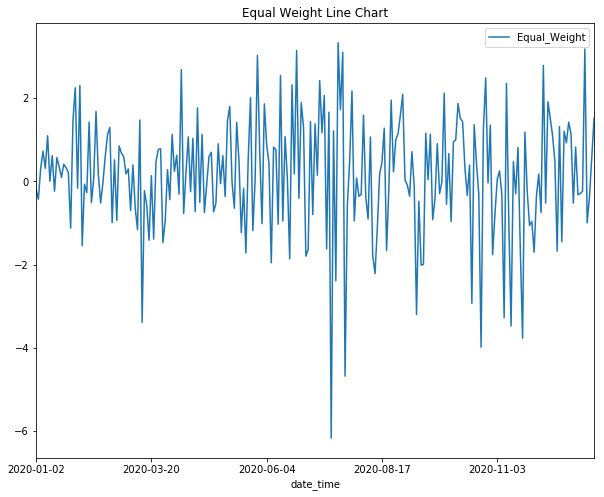

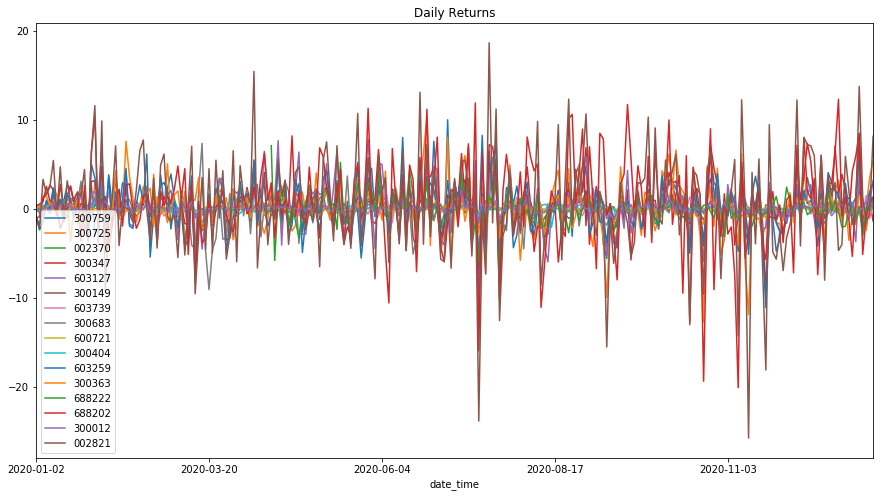

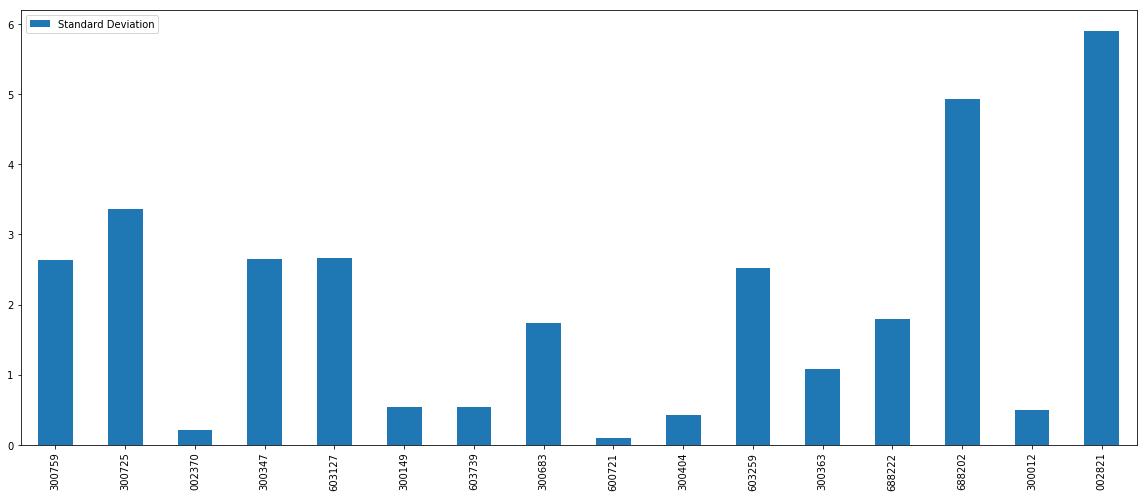

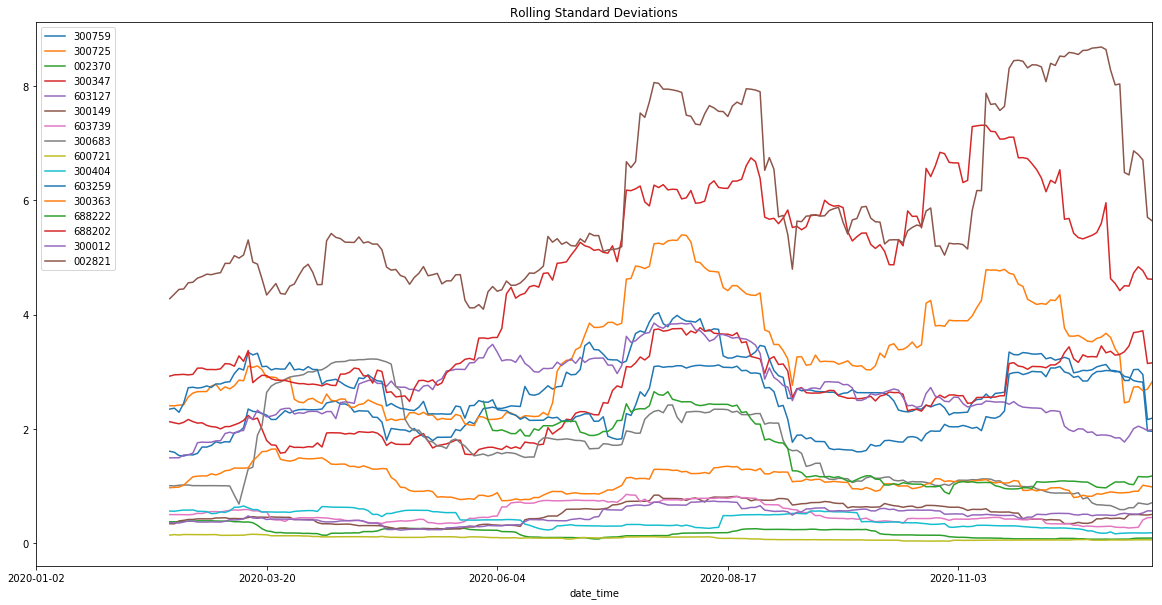

In [41]:
import pandas as pd
from selenium import webdriver
%matplotlib inline
import matplotlib.pyplot as plt
import pandas_bokeh
import time
import os
import requests
from sys import argv
from bs4 import BeautifulSoup


print('started')

chromedriver = 'C:\WebDriver\chromedriver'
os.environ['webdriver.chrome.driver'] = chromedriver
driver = webdriver.Chrome(chromedriver)

driver.get("http://data.eastmoney.com/bkzj/BK0899.html")

# Using xpath find the all the values of the second column of the table
data = driver.find_elements_by_xpath('//*[@id="dataview"]/div[2]/div[2]/table/tbody/tr/td[2]/a')

# Obtained token from investbots website
token = "e2a52669-a76f-8d5b-960e-dfdf4b4cf3aa"

# Add all tickers to the list
tickers = [i.text for i in data]
# Create dataFrame which contains the equal weights
df_data = pd.DataFrame()
df_daily_returns = pd.DataFrame()

# For loop for each ticker 
for i in tickers:
    
#   Get response as list for each ticker.
    response = requests.get(f'https://api.invbots.com/open/v1/internal/stock/cn/{i}/price?token={token}')
    df = pd.DataFrame().from_dict(response.json())

#   Assign a column to keep the equal of the ticker on that particular day
    df = df.assign(equal_weight=(df['close'] - df['open'])*(1/len(tickers)))
    
#   Daily return
    df = df.assign(daily_return=(df['close'] - df['open']))
    
    start_date = '2020-01-01'
    end_date = '2020-12-31'
#   Keeping only the data present from 2020-01-01 to 2020-12-31
    range_data = (df['date_time'] > start_date) & (df['date_time'] <= end_date)
    df = df.loc[range_data]
    
#   Setting the index of the dataFrame to be the date.
    df.set_index(df['date_time'],inplace= True)
#   Appending the data for each sticker to the dataFrame containing all the data
    df_data = df_data.assign(**{i: df['equal_weight']})
#   Appending the daily return for each sticker 
    df_daily_returns = df_daily_returns.assign(**{i:df['daily_return']})
    

# Create a dataFrame which is used to plot the line chart.
plot_graph_e_weight = pd.DataFrame(df_data.sum(axis=1),columns=['Equal_Weight'])
# Reversing the data such that the data starts from 2020-01-01.
plot_graph_e_weight = plot_graph_e_weight.iloc[::-1]

# To plot line chart with the dataFrame containing the equal weight.
plot_graph_e_weight.plot(figsize=(10, 8),title='Equal Weight Line Chart')

# To plot an interactive line chart which opens up in another page.
plot_graph_e_weight.plot_bokeh.line()

# Plot the graph for daily returns
df_daily_returns = df_daily_returns.iloc[::-1]
df_daily_returns.plot(figsize=(15,8),title='Daily Returns')


# Plot the Standard Deviation to find which tickers have high risk
plot_daily_std = pd.DataFrame(df_daily_returns.std(),columns=['Standard Deviation'])
plot_daily_std.plot.bar(figsize = (20,8))

# Rolling Standard Deviation to find the magnitude of increase in risk for a particular time frame
plot_roll_std = df_daily_returns.rolling(window=30).std()
plot_roll_std.plot(figsize = (20,10), title="Rolling Standard Deviations")
plt.margins(x=0)

plt.show()

driver.close()

